In [1]:
import sys
sys.path.append("..")

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xgboost
from satreeverify.xgb_utils import *

/home/masoud/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data = load_breast_cancer()
X = data['data']
y = data["target"]
feature_names = data["feature_names"]
y = y==1

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
ntrees = 50
clf = xgboost.XGBClassifier(n_estimators=ntrees, max_depth=3).fit(x_train, y_train)
clf.score(x_test, y_test)

/home/masoud/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9824561403508771

In [6]:
dump = clf.get_booster().get_dump(dump_format="json")
all_thresh = get_ens_thresh(dump)
data_ = disc_data(x_train[:2,:], all_thresh)
print(data_.shape)
data_.head()

(2, 125)


,23_810.549988,29_0.0695500001,1_19.8299999,27_0.16065,15_0.0142749995,24_0.124500006,4_0.0841100067,3_696.25,27_0.11135,25_0.280250013,...,23_736.400024,25_0.408699989,6_0.093294993,8_0.166299999,11_0.492299974,26_0.190699995,3_694.5,27_0.118200004,22_87.1100006,7_0.0268049985
0,True,True,False,True,True,False,True,True,True,True,...,True,False,True,True,True,True,True,True,True,True
1,False,False,False,False,True,True,True,False,False,False,...,False,False,False,True,True,False,False,False,False,True


In [7]:
var_x = {f"x({i})": Bool(f"x({i})") for i in data_.columns}

# Soft Attack

In [8]:
epsilon = 0.34
index = 12

sample = X[index:index+1, :]
clf.predict_proba(sample)

array([[0.99828535, 0.00171462]], dtype=float32)

In [9]:
s, c_weights = soft_attack(clf, sample, epsilon, var_x)

False
sat


In [10]:
adv_weights = get_output(s, c_weights)
1 / (1 + np.exp(-np.sum([v for k, v in adv_weights.items()])))

0.7172222549678157

In [11]:
clf.predict_proba(sample)[0][1]

0.0017146178

In [12]:
x_adv, x_adv_sample, compare = get_x_adv(s, var_x, sample)
clf.predict_proba(x_adv_sample)[0][1]

0.7172222

In [13]:
compare.sort_values(by=["diff(%)"], ascending=False)

,0,1,diff(%),bound
21,29.940000,20.024955,0.331164,"[-inf, 20.0450001]"
22,151.700000,107.448497,0.291704,"[105.949997, 107.449997]"
23,1332.000000,953.557362,0.284116,"[811.050049, 953.700012]"
25,0.390300,0.279970,0.282681,"[-inf, 0.280250013]"
26,0.363900,0.267256,0.265578,"[0.223450005, 0.26730001]"
27,0.176700,0.136549,0.227225,"[0.135800004, 0.136550009]"
20,20.960000,16.778205,0.199513,"[-inf, 16.7950001]"
1,24.800000,20.234961,0.184074,"[20.1949997, 20.2350006]"
28,0.317600,0.282718,0.109830,"[0.200749993, 0.282800019]"
4,0.097400,0.089490,0.081215,"[0.0841100067, 0.0894950032]"


# Hard Attack

## weight distribution

In [14]:
w = np.asarray([v for k,v in c_weights.items()])
w.min(), w.max()

(-0.574647903, 0.582156122)

(array([ 2.,  4., 21., 25., 73., 52., 33., 14.,  5.,  1.]),
 array([-0.5746479 , -0.4589675 , -0.3432871 , -0.2276067 , -0.11192629,
         0.00375411,  0.11943451,  0.23511491,  0.35079532,  0.46647572,
         0.58215612]),
 <BarContainer object of 10 artists>)

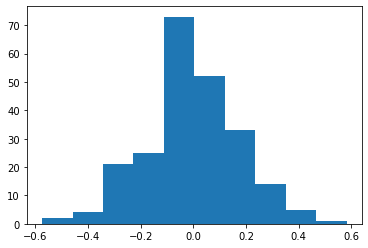

In [15]:
plt.hist(w)

## Attacking sample

In [16]:
epsilon = 0.34
index = 12

nbits = 8
sample = X[index:index+1, :]

In [17]:
s, c_weights, seq_nump, seq_numn = hard_attack(clf, sample, epsilon, var_x, nbits)

False
sat


In [18]:
clf.predict_proba(sample)[0][1]

0.0017146178

In [19]:
adv_weights = get_output(s, c_weights)
val = np.sum([v for k, v in adv_weights.items()])
1 / (1 + np.exp(-val))

0.5050843557567661

In [20]:
x_adv, x_adv_sample, compare = get_x_adv(s, var_x, sample)
clf.predict_proba(x_adv_sample)[0][1]

0.5050844

In [21]:
compare.sort_values(by=["diff(%)"], ascending=False)

,0,1,diff(%),bound
27,0.176700,0.118193,0.331108,"[0.11135, 0.118200004]"
22,151.700000,101.935157,0.328048,"[87.1100006, 101.949997]"
23,1332.000000,953.557362,0.284116,"[811.050049, 953.700012]"
25,0.390300,0.279970,0.282681,"[-inf, 0.280250013]"
26,0.363900,0.267256,0.265578,"[0.223450005, 0.26730001]"
1,24.800000,19.466639,0.215055,"[16.1100006, 19.4699993]"
21,29.940000,23.739610,0.207094,"[23.3499985, 23.7399998]"
20,20.960000,16.778205,0.199513,"[-inf, 16.7950001]"
28,0.317600,0.282718,0.109830,"[0.200749993, 0.282800019]"
4,0.097400,0.090425,0.071617,"[0.0899550021, 0.0904249996]"
